In [185]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

%matplotlib inline

In [2]:
path_img = './data/RealSR(V3)/canon/train/2'
images_lr = []
images_hr = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr.append(read_image(os.path.join(path_img, filename)))
    else:
        images_hr.append(read_image(os.path.join(path_img, filename)))

path_img = './data/RealSR(V3)/canon/test/2'
images_lr_test = []
images_hr_test = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        images_lr_test.append(read_image(os.path.join(path_img, filename)))
    else:
        images_hr_test.append(read_image(os.path.join(path_img, filename)))
        

In [3]:
images_lr_downscales = []
scale = 2
for image in images_lr:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales.append(image_downscale)
    
images_lr_downscales_test = []
scale = 2
for image in images_lr_test:
    resize = torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)))
    image_downscale = resize(image)
    images_lr_downscales_test.append(image_downscale)    

C:\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


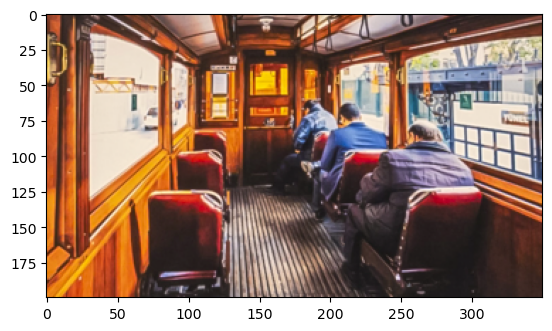

In [4]:
plt.imshow(images_lr_downscales[0].permute(1,2,0))

In [55]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [56]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [57]:
ds_lrdown2lr_train = images_dataset(images_lr_downscales, images_lr)
ds_lrdown2lr_test = images_dataset(images_lr_downscales_test, images_lr_test)

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lrdown2lr_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)#,
                               #num_workers=0,
                               #collate_fn=collate_fn)
dl_lrdown2lr_test = DataLoader(ds_lrdown2lr_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)#,
                               #num_workers=0,
                               #collate_fn=collate_fn)
dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [58]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        x = self.bn(x)
        x = self.activation(x)
        out = x + x_input
        return out
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        
        self.upscale = nn.Upsample(scale_factor=2)
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.GELU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        self.conv_out = nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same')
    
    def forward(self, x):
        x_input = x
        x = self.upscale(x.type(torch.FloatTensor)).to(device)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        out = x
        
        return out
        
        
#    def conv_block(self, channels_in, channels_out, *args, **kwargs):
#        return nn.Sequential(
#            nn.Conv2d(channels_in, channels_out, *args, **kwargs),
#            nn.BatchNorm2d(channels_out),
#            nn.GELU(),

In [127]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data).type(torch.FloatTensor)
                target = batch[1].to(device).type(torch.FloatTensor)
                loss = self.criterion(preds, target)
                loss.backward()
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1

            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()

            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)

            print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\n')

        return self.history

In [128]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [110]:
model = lrdown2lr().to(device)
print(model)

lrdown2lr(
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
  (conv_in): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
  (conv_inner_blocks): ModuleList(
    (0-7): 8 x conv_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
)


In [345]:
torch.cuda.empty_cache()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       epochs=20,
                       dataloader=dl_lrdown2lr)
history = trainer.train()

epoch 1/20; train loss: 540.5543, val_loss: 33.4849 13.750900
epoch 2/20; train loss: 28.8777, val_loss: 21.2721 19.10554999
epoch 3/20; train loss: 19.9687, val_loss: 15.9370 19.03522111


KeyboardInterrupt: 

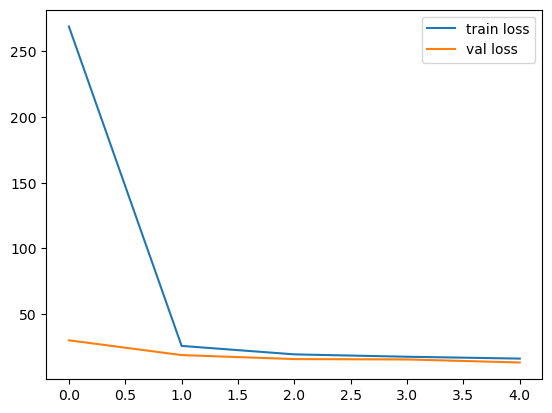

In [13]:
plot_history(history)

In [61]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


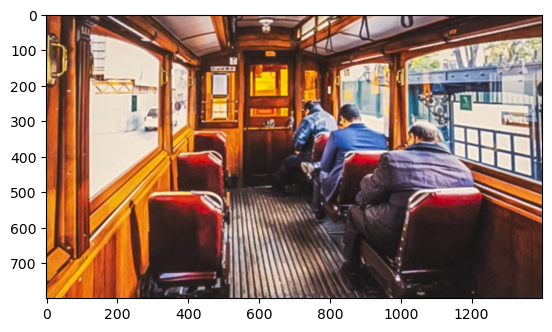

In [346]:
#test = images_lr_downscales[0]
test = images_lr[0]
test = test[None, :]
preds = model(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'test1.png')
plt.imshow(img)

In [16]:
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'test.png')

In [20]:
torch.cuda.empty_cache()

In [24]:
test.device

device(type='cpu')

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [25]:
torchvision.utils.save_image(images_lr_downscales[0]/255., 'test2.png')

In [272]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.up = nn.Upsample(scale_factor=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(5,5), stride=1, padding='same')
        )
        self.act = nn.GELU()
        
    def forward(self, x):
        x = self.up(x)
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)
        return x

In [273]:
ds_deblur_train = images_dataset(images_lr[:1], images_lr[:1])
ds_deblur_test = images_dataset(images_lr_test[:1], images_lr_test[:1])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_train}

ds_deblur_withscale = images_dataset(images_lr_downscales[:1], images_lr[:1])
dl_deblur_withscale = DataLoader(ds_deblur_withscale,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur_withscale = {'train': dl_deblur_withscale, 'test': dl_deblur_withscale}

In [274]:
model_deblur = nn_deblur(1).to(device)
print(model_deblur)

def loss_brisque(y_pred, y_true):
    loss = BRISQUELoss(data_range=255)(y_pred)
    loss = 1/loss*100

    return loss

def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 10000*1/loss + 0.01*nn.L1Loss()(y_pred, y_true)
    return loss

def loss_agm(y_pred, y_true):
    y = y_pred[0]
    gy, gx, gc = torch.gradient(y)
    gnorm = torch.sqrt(gx**2 + gy**2)
    return torch.mean(gnorm) #+ nn.MSELoss()(y_pred, y_true)

def loss_fft(y_pred, y_true):
    return 1/(tensor2freq(y_pred)+1e-10) #+ 0.01*nn.L1Loss()(y_pred, y_true)

criterion_deblur = loss_tv
optimizer = torch.optim.AdamW(model_deblur.parameters(), lr=1e-3)
trainer = torch_trainer(model=model_deblur,
                       criterion=criterion_deblur,
                       optimizer=optimizer,
                       epochs=1000,
                       dataloader=dl_deblur_withscale)
history = trainer.train()


nn_deblur(
  (up): Upsample(scale_factor=2.0, mode='nearest')
  (conv): Sequential(
    (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (act): GELU(approximate='none')
)
epoch 1/1000; train loss: 4.9546, val_loss: 3.8229 3.8229
epoch 2/1000; train loss: 3.8229, val_loss: 3.0500 3.0500
epoch 3/1000; train loss: 3.0500, val_loss: 2.5399 2.5399
epoch 4/1000; train loss: 2.5399, val_loss: 2.2095 2.2095
epoch 5/1000; train loss: 2.2095, val_loss: 1.9990 1.9990
epoch 6/1000; train loss: 1.9990, val_loss: 1.8650 1.8650
epoch 7/1000; train loss: 1.8650, val_loss: 1.7727 1.7727
epoch 8/1000; train loss: 1.7727, val_loss: 1.7018 1.7018
epoch 9/1000; train loss: 1.7018, val_loss: 1.6408 1.6408
epoch 10/1000; train loss: 1.6408, val_loss: 1.5860 1.5860
epoch 11/1000; train loss: 1.5860, val_loss: 1.5356 1.5356
epoch 12/1000; train loss: 1.5356, val_loss: 1.4887 1.4887
epoch 13/1000; train loss: 1.4887, val_loss: 1.4447 1.4447
epoch 14/1000; train loss: 1.4447, val_loss: 1.

epoch 136/1000; train loss: 0.7299, val_loss: 0.7282 0.7282
epoch 137/1000; train loss: 0.7282, val_loss: 0.7265 0.7265
epoch 138/1000; train loss: 0.7265, val_loss: 0.7248 0.7248
epoch 139/1000; train loss: 0.7248, val_loss: 0.7231 0.7231
epoch 140/1000; train loss: 0.7231, val_loss: 0.7214 0.7214
epoch 141/1000; train loss: 0.7214, val_loss: 0.7197 0.7197
epoch 142/1000; train loss: 0.7197, val_loss: 0.7180 0.7180
epoch 143/1000; train loss: 0.7180, val_loss: 0.7163 0.7163
epoch 144/1000; train loss: 0.7163, val_loss: 0.7146 0.7146
epoch 145/1000; train loss: 0.7146, val_loss: 0.7129 0.7129
epoch 146/1000; train loss: 0.7129, val_loss: 0.7113 0.7113
epoch 147/1000; train loss: 0.7113, val_loss: 0.7096 0.7096
epoch 148/1000; train loss: 0.7096, val_loss: 0.7079 0.7079
epoch 149/1000; train loss: 0.7079, val_loss: 0.7063 0.7063
epoch 150/1000; train loss: 0.7063, val_loss: 0.7046 0.7046
epoch 151/1000; train loss: 0.7046, val_loss: 0.7029 0.7029
epoch 152/1000; train loss: 0.7029, val_

epoch 274/1000; train loss: 0.5801, val_loss: 0.5796 0.5796
epoch 275/1000; train loss: 0.5796, val_loss: 0.5791 0.5791
epoch 276/1000; train loss: 0.5791, val_loss: 0.5786 0.5786
epoch 277/1000; train loss: 0.5786, val_loss: 0.5782 0.5782
epoch 278/1000; train loss: 0.5782, val_loss: 0.5777 0.5777
epoch 279/1000; train loss: 0.5777, val_loss: 0.5772 0.5772
epoch 280/1000; train loss: 0.5772, val_loss: 0.5768 0.5768
epoch 281/1000; train loss: 0.5768, val_loss: 0.5763 0.5763
epoch 282/1000; train loss: 0.5763, val_loss: 0.5758 0.5758
epoch 283/1000; train loss: 0.5758, val_loss: 0.5754 0.5754
epoch 284/1000; train loss: 0.5754, val_loss: 0.5749 0.5749
epoch 285/1000; train loss: 0.5749, val_loss: 0.5745 0.5745
epoch 286/1000; train loss: 0.5745, val_loss: 0.5740 0.5740
epoch 287/1000; train loss: 0.5740, val_loss: 0.5736 0.5736
epoch 288/1000; train loss: 0.5736, val_loss: 0.5732 0.5732
epoch 289/1000; train loss: 0.5732, val_loss: 0.5727 0.5727
epoch 290/1000; train loss: 0.5727, val_

epoch 411/1000; train loss: 0.5275, val_loss: 0.5272 0.5272
epoch 412/1000; train loss: 0.5272, val_loss: 0.5269 0.5269
epoch 413/1000; train loss: 0.5269, val_loss: 0.5265 0.5265
epoch 414/1000; train loss: 0.5265, val_loss: 0.5262 0.5262
epoch 415/1000; train loss: 0.5262, val_loss: 0.5258 0.5258
epoch 416/1000; train loss: 0.5258, val_loss: 0.5255 0.5255
epoch 417/1000; train loss: 0.5255, val_loss: 0.5252 0.5252
epoch 418/1000; train loss: 0.5252, val_loss: 0.5248 0.5248
epoch 419/1000; train loss: 0.5248, val_loss: 0.5245 0.5245
epoch 420/1000; train loss: 0.5245, val_loss: 0.5242 0.5242
epoch 421/1000; train loss: 0.5242, val_loss: 0.5238 0.5238
epoch 422/1000; train loss: 0.5238, val_loss: 0.5235 0.5235
epoch 423/1000; train loss: 0.5235, val_loss: 0.5232 0.5232
epoch 424/1000; train loss: 0.5232, val_loss: 0.5228 0.5228
epoch 425/1000; train loss: 0.5228, val_loss: 0.5225 0.5225
epoch 426/1000; train loss: 0.5225, val_loss: 0.5222 0.5222
epoch 427/1000; train loss: 0.5222, val_

epoch 548/1000; train loss: 0.4833, val_loss: 0.4830 0.4830
epoch 549/1000; train loss: 0.4830, val_loss: 0.4827 0.4827
epoch 550/1000; train loss: 0.4827, val_loss: 0.4824 0.4824
epoch 551/1000; train loss: 0.4824, val_loss: 0.4821 0.4821
epoch 552/1000; train loss: 0.4821, val_loss: 0.4818 0.4818
epoch 553/1000; train loss: 0.4818, val_loss: 0.4815 0.4815
epoch 554/1000; train loss: 0.4815, val_loss: 0.4812 0.4812
epoch 555/1000; train loss: 0.4812, val_loss: 0.4809 0.4809
epoch 556/1000; train loss: 0.4809, val_loss: 0.4806 0.4806
epoch 557/1000; train loss: 0.4806, val_loss: 0.4803 0.4803
epoch 558/1000; train loss: 0.4803, val_loss: 0.4800 0.4800
epoch 559/1000; train loss: 0.4800, val_loss: 0.4797 0.4797
epoch 560/1000; train loss: 0.4797, val_loss: 0.4793 0.4793
epoch 561/1000; train loss: 0.4793, val_loss: 0.4790 0.4790
epoch 562/1000; train loss: 0.4790, val_loss: 0.4787 0.4787
epoch 563/1000; train loss: 0.4787, val_loss: 0.4784 0.4784
epoch 564/1000; train loss: 0.4784, val_

epoch 685/1000; train loss: 0.4459, val_loss: 0.4457 0.4457
epoch 686/1000; train loss: 0.4457, val_loss: 0.4455 0.4455
epoch 687/1000; train loss: 0.4455, val_loss: 0.4453 0.4453
epoch 688/1000; train loss: 0.4453, val_loss: 0.4450 0.4450
epoch 689/1000; train loss: 0.4450, val_loss: 0.4448 0.4448
epoch 690/1000; train loss: 0.4448, val_loss: 0.4446 0.4446
epoch 691/1000; train loss: 0.4446, val_loss: 0.4444 0.4444
epoch 692/1000; train loss: 0.4444, val_loss: 0.4442 0.4442
epoch 693/1000; train loss: 0.4442, val_loss: 0.4439 0.4439
epoch 694/1000; train loss: 0.4439, val_loss: 0.4437 0.4437
epoch 695/1000; train loss: 0.4437, val_loss: 0.4435 0.4435
epoch 696/1000; train loss: 0.4435, val_loss: 0.4433 0.4433
epoch 697/1000; train loss: 0.4433, val_loss: 0.4431 0.4431
epoch 698/1000; train loss: 0.4431, val_loss: 0.4429 0.4429
epoch 699/1000; train loss: 0.4429, val_loss: 0.4427 0.4427
epoch 700/1000; train loss: 0.4427, val_loss: 0.4425 0.4425
epoch 701/1000; train loss: 0.4425, val_

epoch 823/1000; train loss: 0.4228, val_loss: 0.4226 0.4226
epoch 824/1000; train loss: 0.4226, val_loss: 0.4225 0.4225
epoch 825/1000; train loss: 0.4225, val_loss: 0.4224 0.4224
epoch 826/1000; train loss: 0.4224, val_loss: 0.4223 0.4223
epoch 827/1000; train loss: 0.4223, val_loss: 0.4221 0.4221
epoch 828/1000; train loss: 0.4221, val_loss: 0.4220 0.4220
epoch 829/1000; train loss: 0.4220, val_loss: 0.4219 0.4219
epoch 830/1000; train loss: 0.4219, val_loss: 0.4218 0.4218
epoch 831/1000; train loss: 0.4218, val_loss: 0.4217 0.4217
epoch 832/1000; train loss: 0.4217, val_loss: 0.4215 0.4215
epoch 833/1000; train loss: 0.4215, val_loss: 0.4214 0.4214
epoch 834/1000; train loss: 0.4214, val_loss: 0.4213 0.4213
epoch 835/1000; train loss: 0.4213, val_loss: 0.4212 0.4212
epoch 836/1000; train loss: 0.4212, val_loss: 0.4211 0.4211
epoch 837/1000; train loss: 0.4211, val_loss: 0.4209 0.4209
epoch 838/1000; train loss: 0.4209, val_loss: 0.4208 0.4208
epoch 839/1000; train loss: 0.4208, val_

epoch 961/1000; train loss: 0.4086, val_loss: 0.4085 0.4085
epoch 962/1000; train loss: 0.4085, val_loss: 0.4084 0.4084
epoch 963/1000; train loss: 0.4084, val_loss: 0.4083 0.4083
epoch 964/1000; train loss: 0.4083, val_loss: 0.4082 0.4082
epoch 965/1000; train loss: 0.4082, val_loss: 0.4081 0.4081
epoch 966/1000; train loss: 0.4081, val_loss: 0.4081 0.4081
epoch 967/1000; train loss: 0.4081, val_loss: 0.4080 0.4080
epoch 968/1000; train loss: 0.4080, val_loss: 0.4079 0.4079
epoch 969/1000; train loss: 0.4079, val_loss: 0.4078 0.4078
epoch 970/1000; train loss: 0.4078, val_loss: 0.4077 0.4077
epoch 971/1000; train loss: 0.4077, val_loss: 0.4076 0.4076
epoch 972/1000; train loss: 0.4076, val_loss: 0.4075 0.4075
epoch 973/1000; train loss: 0.4075, val_loss: 0.4075 0.4075
epoch 974/1000; train loss: 0.4075, val_loss: 0.4074 0.4074
epoch 975/1000; train loss: 0.4074, val_loss: 0.4073 0.4073
epoch 976/1000; train loss: 0.4073, val_loss: 0.4072 0.4072
epoch 977/1000; train loss: 0.4072, val_

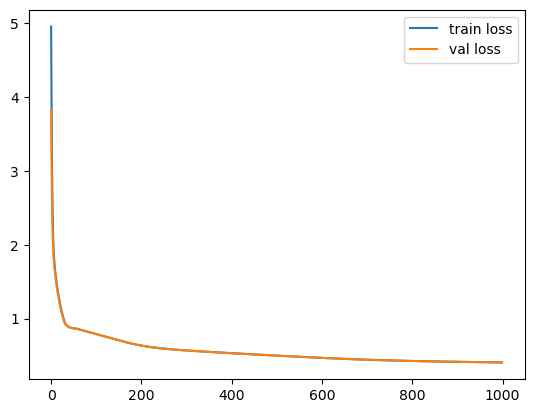

In [275]:
plot_history(history)

tensor(0.8827)


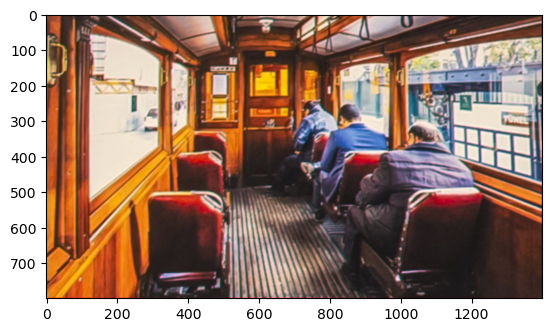

In [276]:
test = images_lr[0]
#test = read_image('out_before.png')
test = test[None, :]
model_deblur.eval()
with torch.no_grad():
    preds = model_deblur(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_ = ssim(preds, ref, data_range=255)
print(ssim_)

In [49]:
output

tensor(90.6459, grad_fn=<MeanBackward1>)

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


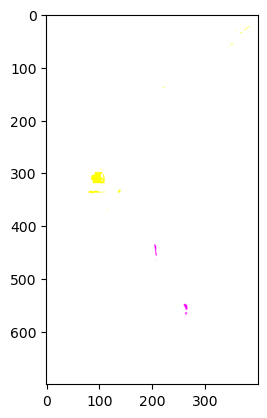

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
for im in dl_deblur['train']:
    print (im)
    break

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,